In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
dataset = pd.read_csv("data/etrain.csv")
num_features = np.load('numeric_features.npy')
validation = pd.read_csv("data/evalidation.csv")
test = pd.read_csv("data/etest.csv")
orig_dataset = pd.read_csv('dataset.csv')

In [87]:
num_features

array(['Total Food Expenditure', 'Agricultural Household indicator',
       'Bread and Cereals Expenditure', 'Total Rice Expenditure',
       'Meat Expenditure', 'Total Fish and  marine products Expenditure',
       'Fruit Expenditure', 'Vegetables Expenditure',
       'Restaurant and hotels Expenditure',
       'Alcoholic Beverages Expenditure', 'Tobacco Expenditure',
       'Clothing, Footwear and Other Wear Expenditure',
       'Housing and water Expenditure', 'Imputed House Rental Value',
       'Medical Care Expenditure', 'Transportation Expenditure',
       'Communication Expenditure', 'Education Expenditure',
       'Miscellaneous Goods and Services Expenditure',
       'Special Occasions Expenditure',
       'Crop Farming and Gardening expenses',
       'Total Income from Entrepreneurial Acitivites',
       'Household Head Age', 'Total Number of Family members',
       'Members with age less than 5 year old',
       'Members with age 5 - 17 years old',
       'Total number of f

In [79]:
len(dataset.columns)

178

In [80]:
orig_dataset[np.append(num_features, 'Total Household Income')].corr().loc['Total Food Expenditure', 'Total Household Income']

0.6636599516040624

<AxesSubplot:xlabel='Total Food Expenditure', ylabel='Total Household Income'>

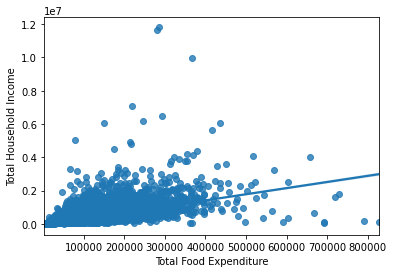

In [81]:
sns.regplot(x=orig_dataset['Total Food Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Miscellaneous Goods and Services Expenditure', ylabel='Total Household Income'>

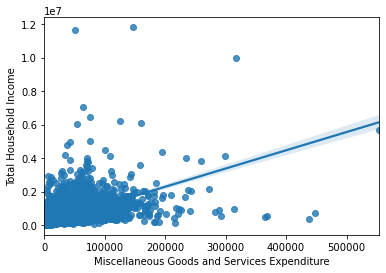

In [82]:
sns.regplot(x=orig_dataset['Miscellaneous Goods and Services Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Housing and water Expenditure', ylabel='Total Household Income'>

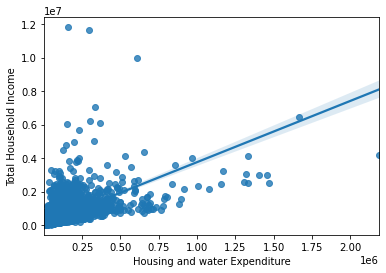

In [83]:
sns.regplot(x=orig_dataset['Housing and water Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Communication Expenditure', ylabel='Total Household Income'>

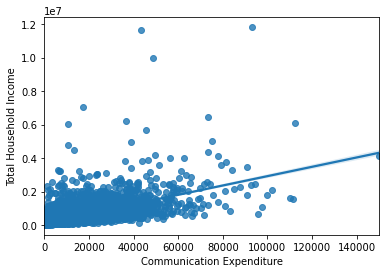

In [84]:
sns.regplot(x=orig_dataset['Communication Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Total Income from Entrepreneurial Acitivites', ylabel='Total Household Income'>

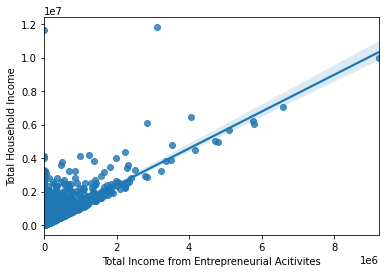

In [88]:
sns.regplot(x=orig_dataset['Total Income from Entrepreneurial Acitivites'], y=orig_dataset['Total Household Income'])

<AxesSubplot:>

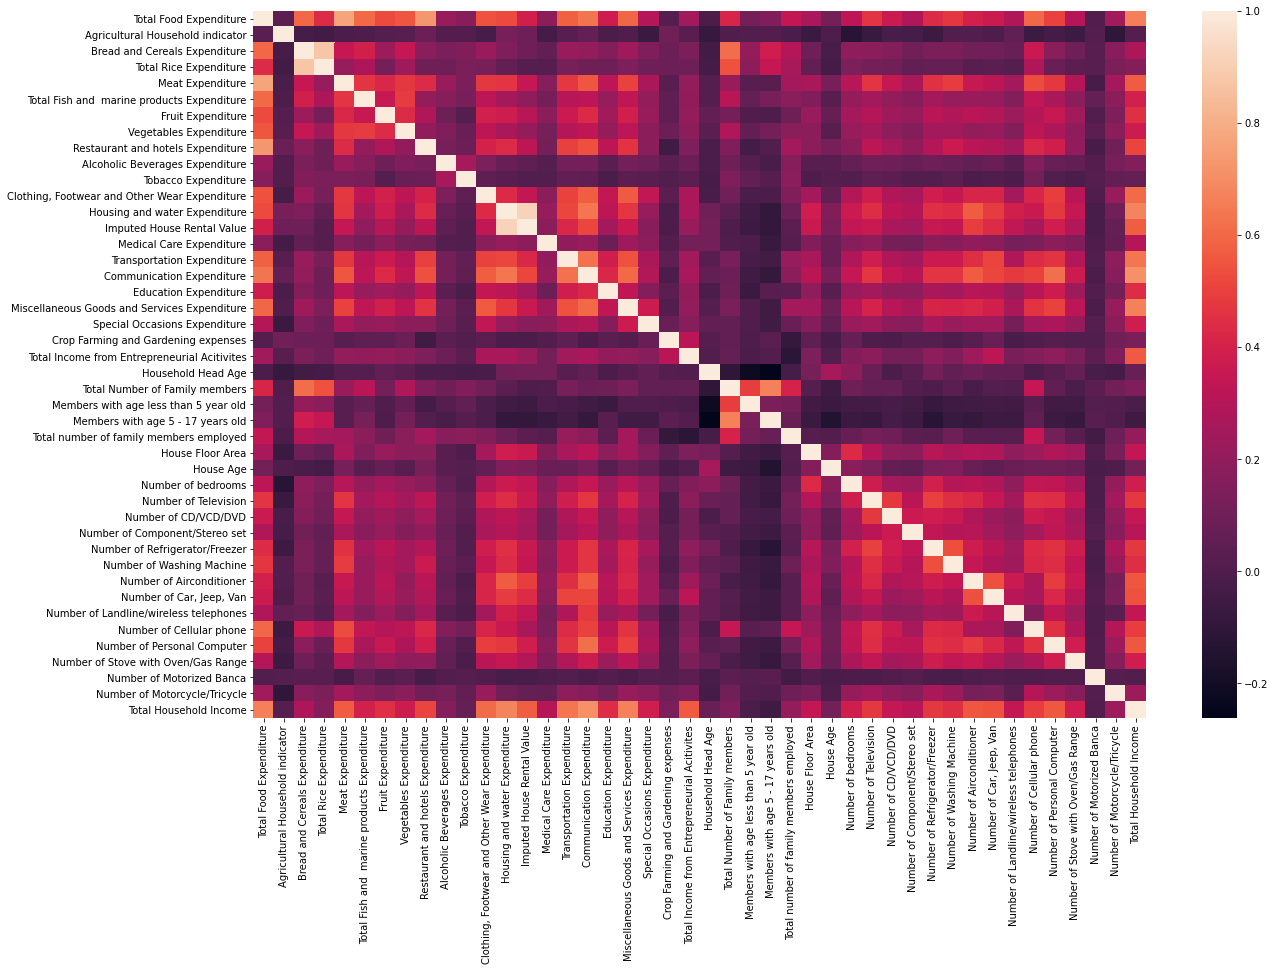

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 13))
sns.heatmap(orig_dataset[np.append(num_features, 'Total Household Income')].corr())

<AxesSubplot:>

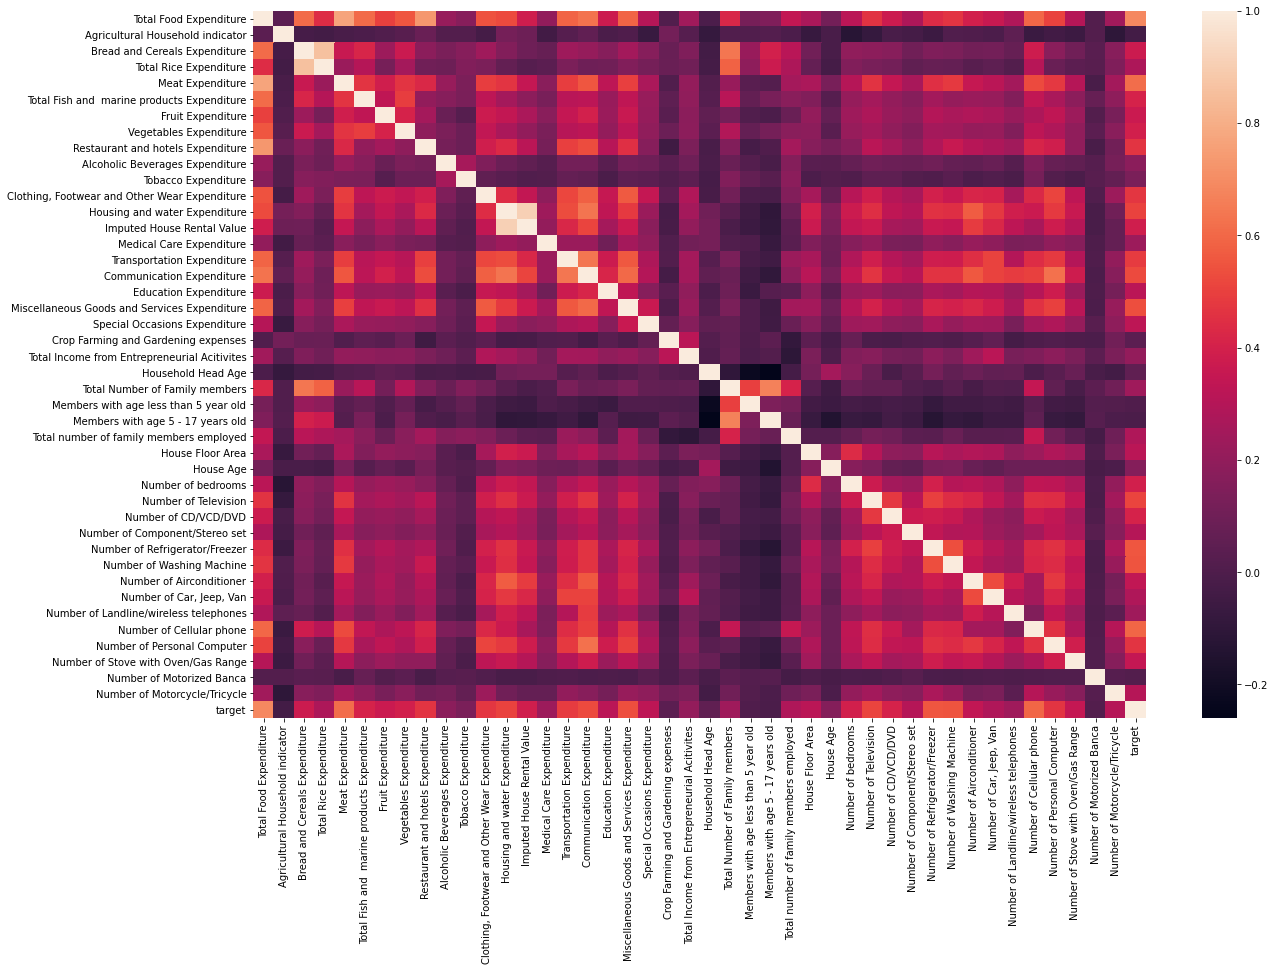

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 13))
sns.heatmap(dataset[np.append(num_features, 'target')].corr())

In [54]:
features = dataset.drop(['target'], axis=1).columns
#features = dataset.drop(['target'], axis=1).drop(num_features, axis=1).columns
#features = dataset[num_features].columns

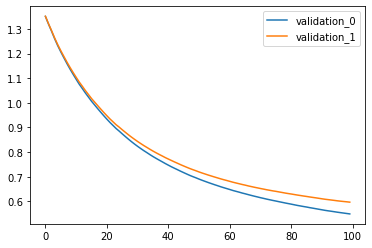

In [55]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
rng = np.random.RandomState(31337)

# min_child_weight (float) – Minimum sum of instance weight(hessian) needed in a child.

# max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.

# subsample (float) – Subsample ratio of the training instance.

# colsample_bytree (float) – Subsample ratio of columns when constructing each tree.

# colsample_bylevel (float) – Subsample ratio of columns for each level.

# colsample_bynode (float) – Subsample ratio of columns for each split.

# reg_alpha (float (xgb's alpha)) – L1 regularization term on weights

# reg_lambda (float (xgb's lambda)) – L2 regularization term on weights

# scale_pos_weight (float) – Balancing of positive and negative weights.

# base_score – The initial prediction score of all instances, global bias.
y = dataset['target'].values
X = dataset[features].values
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.04, objective='multi:softmax', booster='gbtree',
                              reg_alpha=2.0, reg_lambda=2.5, gamma=0.5, min_child_weight=2.0, colsample_bytree=0.7,
                              subsample=0.5, use_label_encoder=False, n_jobs=-1, random_state=1)
xgb_model.fit(X, y,
                eval_set=[(X, y), (validation[features].values, validation['target'].values)],
                eval_metric='mlogloss',
                verbose=False)
# xgb_model.evals_result()
# predictions = xgb_model.predict(validation[features].values)
# actuals = validation['target'].values
# print(multilabel_confusion_matrix(actuals, predictions))
losses = xgb_model.evals_result()
label = ["train", 'validation', 'test']
plt.figure()
for key, v in losses.items():
    plt.plot(range(100), v['mlogloss'], label=key)
plt.legend()
plt.show()

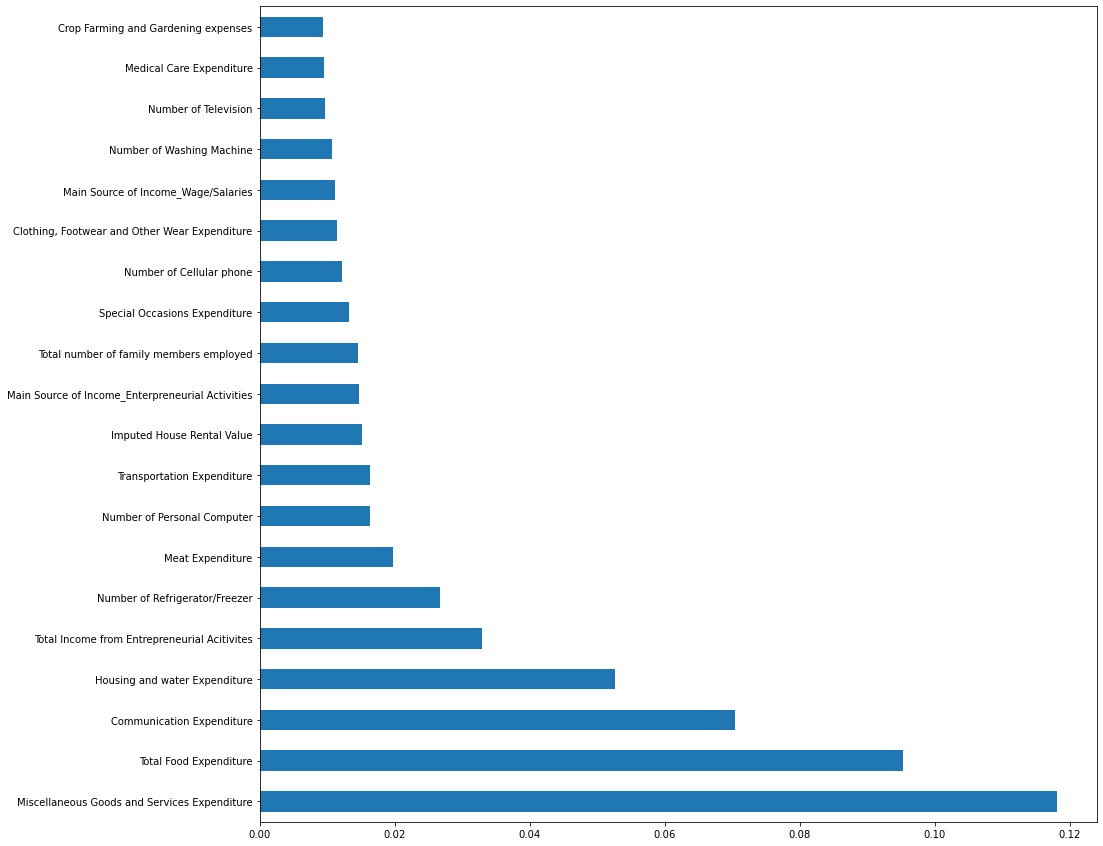

In [57]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=dataset[features].columns)
plt.figure(figsize=(15, 15))
f = feat_importances.nlargest(20)
f.plot(kind='barh')
plt.show()

In [59]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print("\nTrain:")
predictions = xgb_model.predict(X)
print(classification_report(y, predictions))
print("\nValidation:")
predictions = xgb_model.predict(validation[features].values)
print(classification_report(validation['target'].values, predictions))
print("\nTest:")
predictions = xgb_model.predict(test[features].values)
print(classification_report(test['target'].values, predictions))


Train:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      6648
           1       0.71      0.72      0.71      6586
           2       0.74      0.74      0.74      6688
           3       0.91      0.86      0.89      6666

    accuracy                           0.80     26588
   macro avg       0.80      0.80      0.80     26588
weighted avg       0.80      0.80      0.80     26588


Validation:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1688
           1       0.66      0.68      0.67      1709
           2       0.67      0.67      0.67      1588
           3       0.89      0.83      0.86      1662

    accuracy                           0.76      6647
   macro avg       0.76      0.76      0.76      6647
weighted avg       0.76      0.76      0.76      6647


Test:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83    

## Feature selection #1

In [10]:
from minisom import MiniSom

In [74]:
feature_names = ['Total Rice Expenditure', 'Bread and Cereals Expenditure', 'Imputed House Rental Value', 'Housing and water Expenditure', 'Members with age 5 - 17 years old', 'Total Number of Family members']
X = dataset[feature_names].values

In [75]:
size = 10
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.030234908506501595


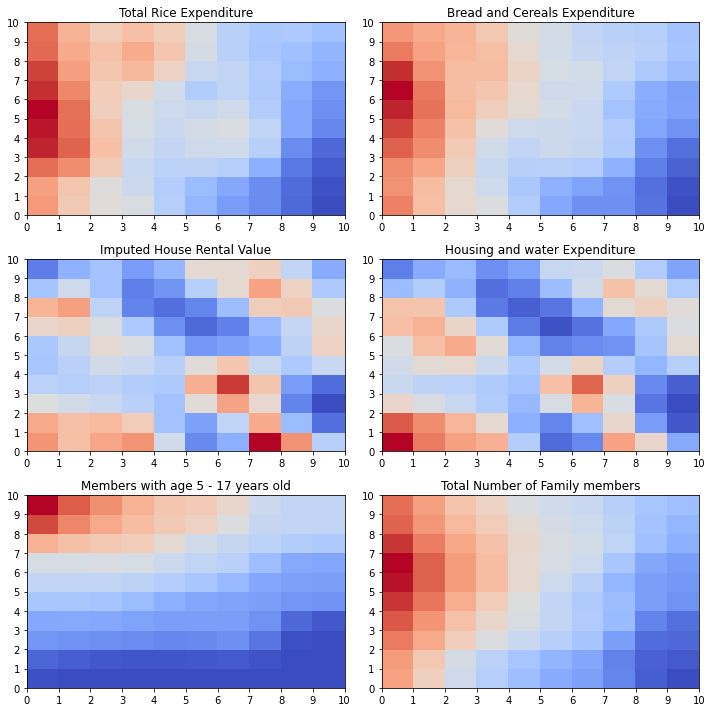

In [76]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 2, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

<AxesSubplot:>

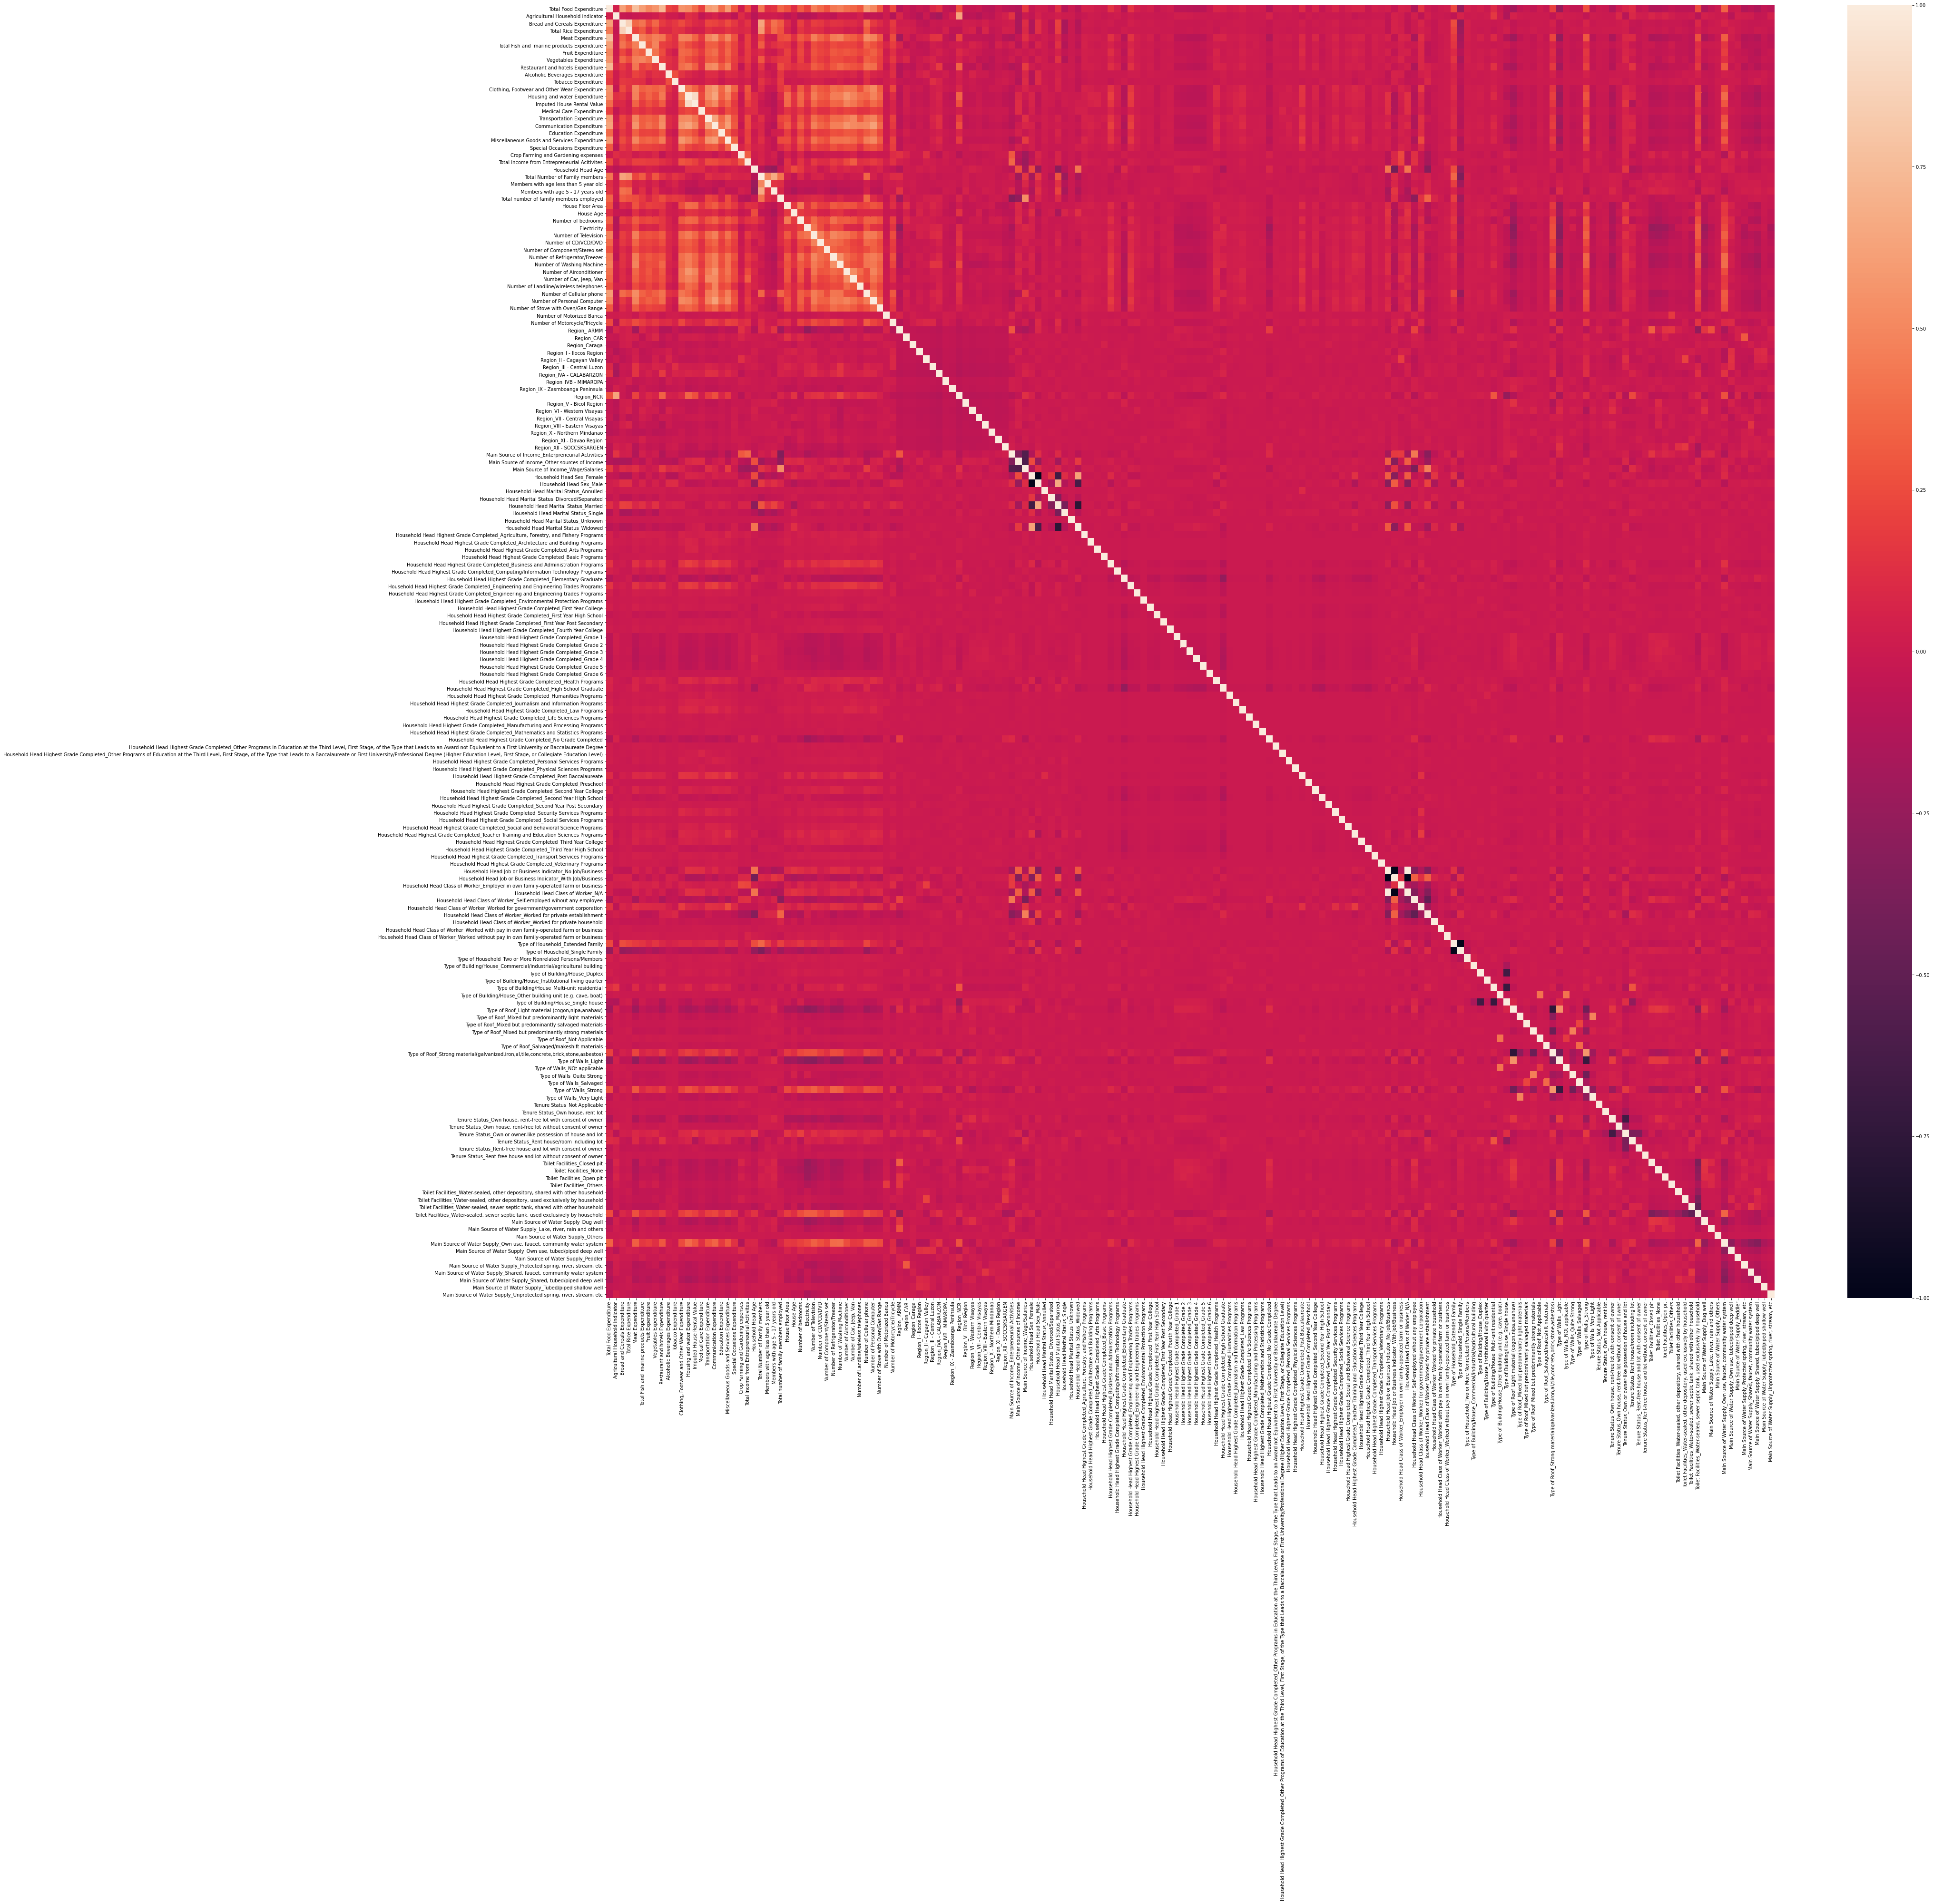

In [8]:
plt.figure(figsize=(55, 50))
sns.heatmap(dataset.drop('target', axis=1).corr())

## Feature selection #2

In [60]:
features = features.drop(['Total Rice Expenditure', 'Imputed House Rental Value'])

In [61]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X = dataset[features].values
y = dataset['target'].values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	9 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	10 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	11 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	12 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	13 / 100
Confirmed: 	62
Tentative: 	20
Rejected: 	93
Iteration: 	14 / 100
Confirmed: 	62
Tentative: 	20
Rejected: 	93
Iteration: 	15 / 100
Confirmed: 	62
Tentative: 	20
Rejected: 	93
Iteration: 	16 / 100
Confirmed: 	62
Tenta

In [62]:
tmp = dataset[features].loc[:, feat_selector.support_]
# tmp = pd.concat([tmp, dataset['target']], axis=1)

<AxesSubplot:>

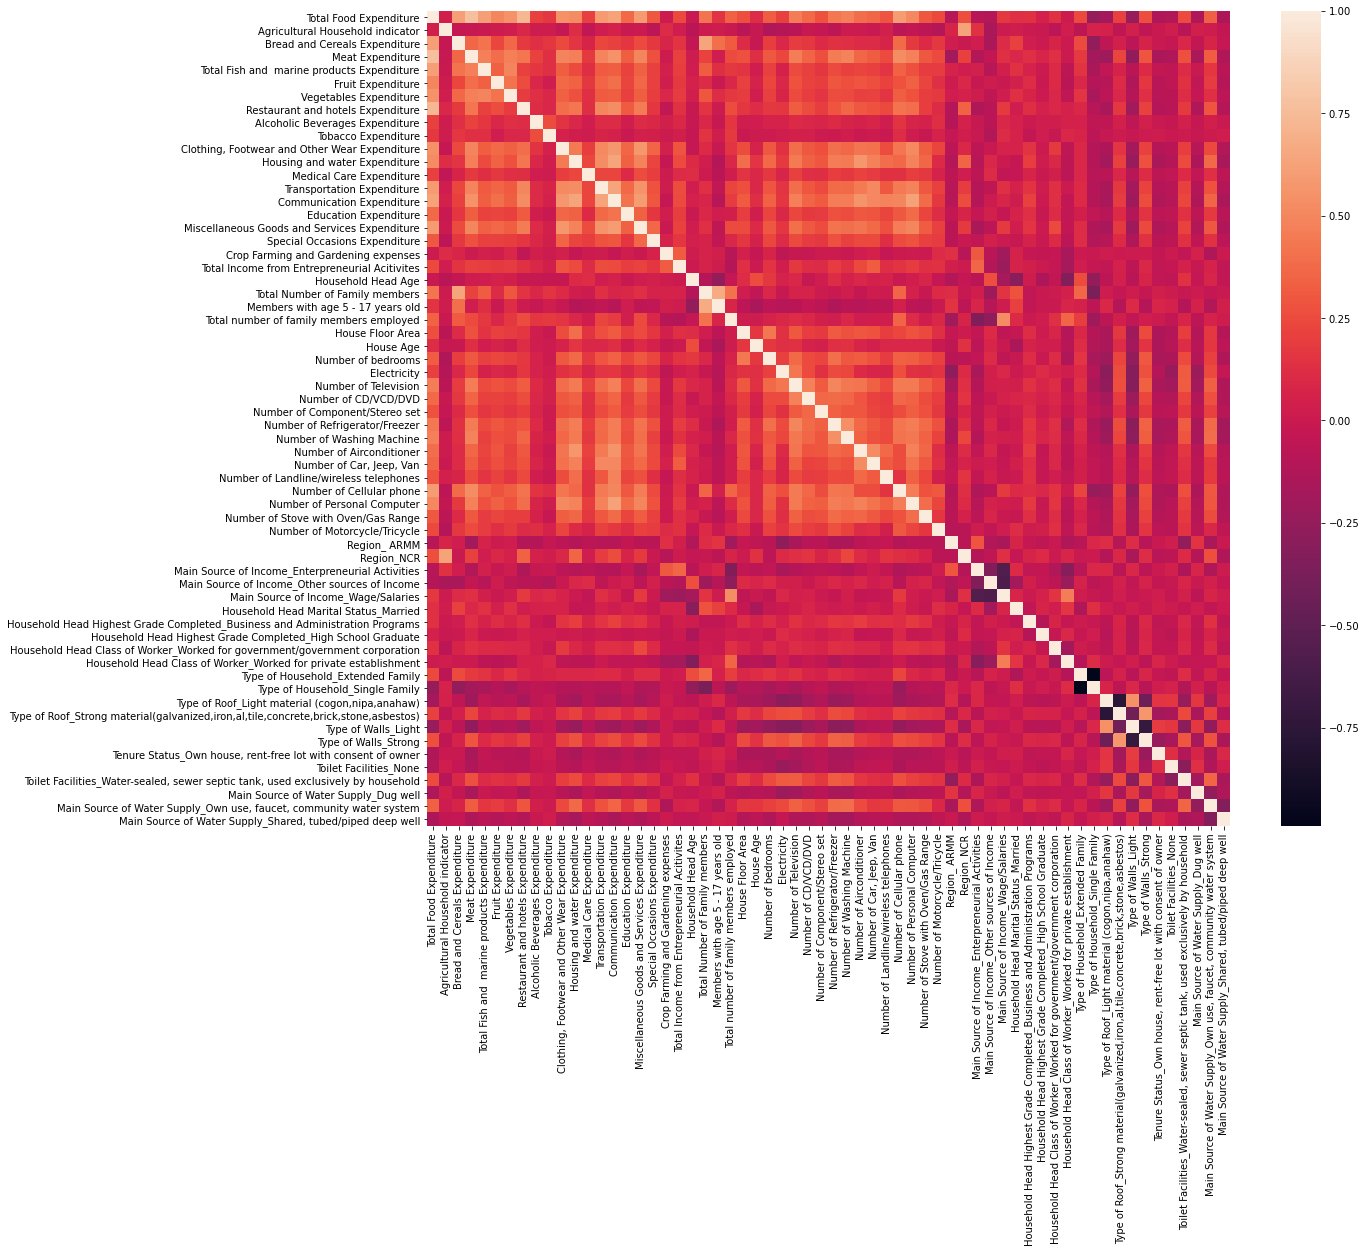

In [63]:
plt.figure(figsize=(18, 15))
sns.heatmap(tmp.corr())

In [64]:
DC = RandomForestClassifier(criterion='entropy')
DC.fit(tmp, dataset['target'])
DC.feature_importances_

array([0.10847641, 0.00399344, 0.02219522, 0.0530165 , 0.02142376,
       0.02503196, 0.02139822, 0.03062956, 0.01272216, 0.01149969,
       0.04216327, 0.090456  , 0.02496107, 0.04927073, 0.06487851,
       0.01784341, 0.08980862, 0.02630979, 0.00996795, 0.03707299,
       0.01702319, 0.01042729, 0.00739926, 0.01100123, 0.01832091,
       0.01532211, 0.00828545, 0.00136183, 0.0097347 , 0.00405965,
       0.00204221, 0.0203854 , 0.01431208, 0.004368  , 0.00142602,
       0.00058381, 0.02261849, 0.01149435, 0.00188063, 0.00408843,
       0.00105004, 0.00144142, 0.002968  , 0.00284056, 0.00334691,
       0.00251016, 0.00057682, 0.00268673, 0.00125978, 0.00298295,
       0.00257662, 0.00266304, 0.00136292, 0.00199158, 0.00289191,
       0.00380453, 0.00193432, 0.00059729, 0.00325706, 0.00139452,
       0.00456816, 0.00204038])

In [65]:
DC.score(feat_selector.transform(test[features].values), test['target'])

0.7502707907088699

In [66]:
DC.score(tmp, dataset['target'])

1.0

In [67]:
features = tmp.columns
np.save('selected_features', features)

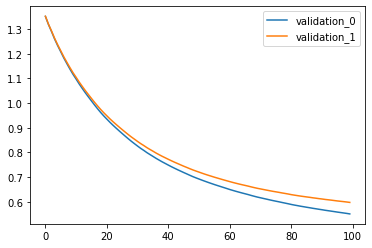

In [68]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
rng = np.random.RandomState(31337)

# min_child_weight (float) – Minimum sum of instance weight(hessian) needed in a child.

# max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.

# subsample (float) – Subsample ratio of the training instance.

# colsample_bytree (float) – Subsample ratio of columns when constructing each tree.

# colsample_bylevel (float) – Subsample ratio of columns for each level.

# colsample_bynode (float) – Subsample ratio of columns for each split.

# reg_alpha (float (xgb's alpha)) – L1 regularization term on weights

# reg_lambda (float (xgb's lambda)) – L2 regularization term on weights

# scale_pos_weight (float) – Balancing of positive and negative weights.

# base_score – The initial prediction score of all instances, global bias.
y = dataset['target'].values
X = dataset[features].values
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.04, objective='multi:softmax', booster='gbtree',
                              reg_alpha=2.0, reg_lambda=2.5, gamma=0.5, min_child_weight=2.0, colsample_bytree=0.7,
                              subsample=0.5, use_label_encoder=False, n_jobs=-1, random_state=1)
xgb_model.fit(X, y,
                eval_set=[(X, y), (validation[features].values, validation['target'].values)],
                eval_metric='mlogloss',
                verbose=False)
# xgb_model.evals_result()
# predictions = xgb_model.predict(validation[features].values)
# actuals = validation['target'].values
# print(multilabel_confusion_matrix(actuals, predictions))
losses = xgb_model.evals_result()
label = ["train", 'validation', 'test']
plt.figure()
for key, v in losses.items():
    plt.plot(range(100), v['mlogloss'], label=key)
plt.legend()
plt.show()

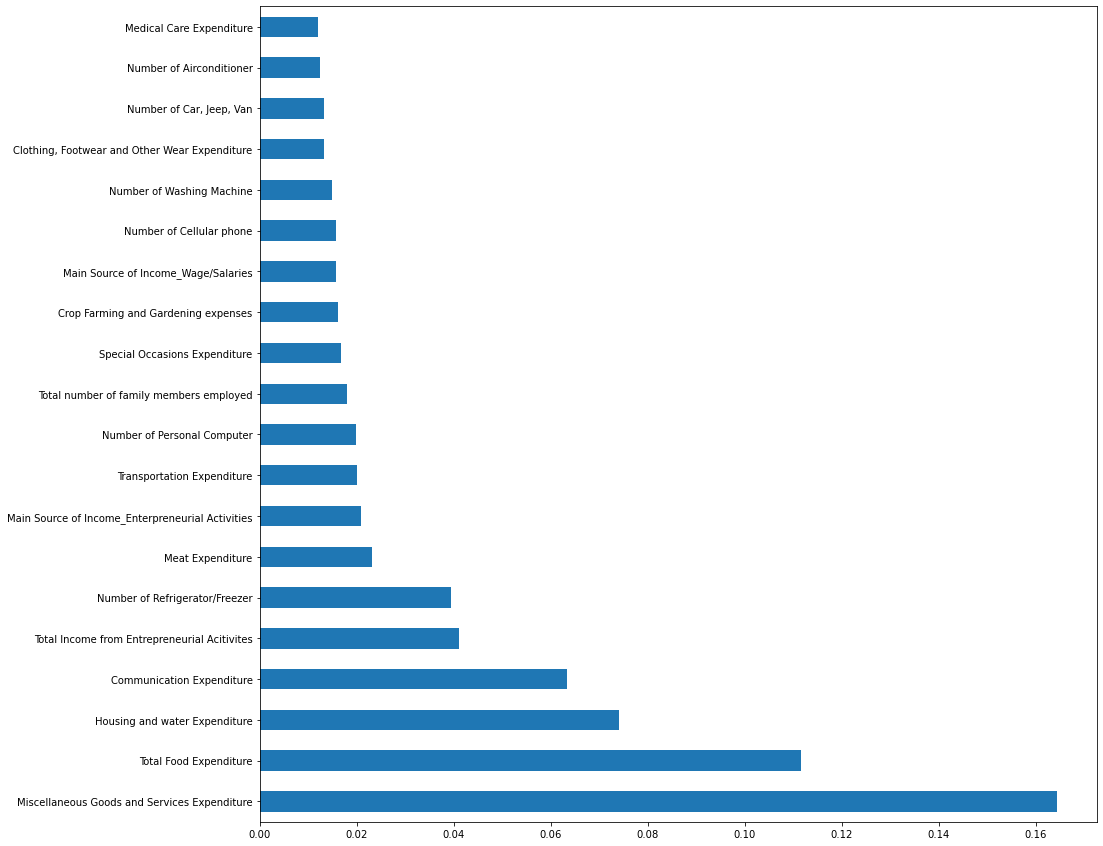

In [72]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=dataset[features].columns)
plt.figure(figsize=(15, 15))
f = feat_importances.nlargest(20)
f.plot(kind='barh')
plt.show()

In [70]:
predictions = xgb_model.predict(X)
actuals = y
print(confusion_matrix(actuals, predictions))
predictions = xgb_model.predict(validation[features].values)
actuals = validation['target'].values
print(confusion_matrix(actuals, predictions))
predictions = xgb_model.predict(test[features].values)
actuals = test['target'].values
print(confusion_matrix(actuals, predictions))

[[5807  804   36    1]
 [ 958 4807  812    9]
 [  87 1180 4896  525]
 [  13   65  868 5720]]
[[1449  232    6    1]
 [ 289 1162  256    2]
 [  22  336 1063  167]
 [   4   21  266 1371]]
[[1735  304   12    0]
 [ 356 1421  312    1]
 [  29  457 1412  212]
 [   2   29  304 1723]]


In [71]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print("\nTrain:")
predictions = xgb_model.predict(X)
print(classification_report(y, predictions))
print("\nValidation:")
predictions = xgb_model.predict(validation[features].values)
print(classification_report(validation['target'].values, predictions))
print("\nTest:")
predictions = xgb_model.predict(test[features].values)
print(classification_report(test['target'].values, predictions))


Train:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6648
           1       0.70      0.73      0.72      6586
           2       0.74      0.73      0.74      6688
           3       0.91      0.86      0.89      6666

    accuracy                           0.80     26588
   macro avg       0.80      0.80      0.80     26588
weighted avg       0.80      0.80      0.80     26588


Validation:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1688
           1       0.66      0.68      0.67      1709
           2       0.67      0.67      0.67      1588
           3       0.89      0.82      0.86      1662

    accuracy                           0.76      6647
   macro avg       0.76      0.76      0.76      6647
weighted avg       0.76      0.76      0.76      6647


Test:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83    